##Ferdinand Beaman        Capstone Project     April 2024

My students often ask what I'm doing "in school", and more than once I've gotten this response when I tell them:

"That sounds *boooring*"

But when I say "That's because you didn't try to predict stock prices yet",that always raises the eyebrows.

"Day trader" is a surprisingly common self-identifier, despite the fact that most people who try their hand at is are overwhelmingly bad at it. The stock market, on the whole, climbs up in value year after year. But, depending on the source, it's assumed that anywhere between 90 and 99% of people who take part in day trading lose money. My personal hypothesis? Human beings are overconfident pattern seekers and would benefit greatly from some scientific rigor. They learn trading "strategies" that involve reading what may amount to just tea leaves, and lose. Beyond the fallability of humans, there is also the theory of the ["Efficient-market hypothesis"](https://en.m.wikipedia.org/wiki/Efficient-market_hypothesis) in the way.

However, neural networks may have the power to make this a viable path. While a NN may not have access to the latest news on Elon Musk or global pandemics, and thus have poor predictive powers long term, they may have the ability to sift through the chaos over shorter timescales and do well. After all, in any given hour it's unlikely that a CEO will get caught for insider trading or a boat will get stuck in a canal and shut down global trade for days.

> Here stands my business problem: Can I use new stock price information (up to an hour old) to predict impending prices for a client, live?


The data I'm using comes from https://firstratedata.com/, but in the interest of reprodicibility I should mention that their free samples seem to be tied to the day you request for them. My sample covered an 11 day span of minute-to-minute data beginning near the end of February 2024. (Due to this small sample, I didn't feel the need to account for any cyclical trends).

I chose to use GRU as my NN based on [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9141105/#). It ended up paying off quite a bit since some of my cells took over an hour to run. I would not want to rerun them with something more computationally demanding, like an LSTM.

I used a "walk forward" strategy to train my models, and used 5 different step-sizes: 25, 34, 45, 60, and 80 minutes (each step down is a 25% reduction). It quickly became apparent that the 80 minute models didn't have enough room to make enough steps for training and were scrapped midway through.

# 1.0 Data Exploration and Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# !pip install numpy==1.23.0
# One of the later cells refused to function with the newest numpy
# I found that it works up to ver 1.25.2
import numpy as np

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

from datetime import datetime as dt

from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import GRU
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import keras

In [2]:
print(np.__version__) #double checking the numpy version

1.25.2


I chose these seven stocks based on two criteria:


1.   They were in unrelated fields
2.   They had enough activity over my 11 days to have at least 4,000 data points

Ultimately, I settled on American Airlines, FedEx, Fidelity, Macy's, Sprint, Starbucks, and Tesla.


In [76]:
#American Airlines
df_aal = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/AAL_1min_sample.csv")
#Fed Ex
df_fdx = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/FDX_1min_sample.csv")
#Fidelity National
df_fis = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/FIS_1min_sample.csv")
#Macy's
df_mcy = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/M_1min_sample.csv")
#Sprint
df_spr = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/S_1min_sample.csv")
#Starbucks
df_sbx = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/SBUX_1min_sample.csv")
#Tesla
df_tsl = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/TSLA_1min_sample.csv")

all_dfs = [df_aal, df_fdx, df_fis, df_mcy, df_sbx, df_spr, df_tsl]

In [77]:
# The stock names will replace the "open" column, which will clarify things
# once the dfs are all concatenated
stock_names = ["American_airlines", "Fed_ex", "Fidelity", "Macys", "Sprint", "Starbucks", "Tesla"]

for i, stock in enumerate(all_dfs):
  stock.rename(columns={"open": stock_names[i]}, inplace= True)

How many data points do I have?

In [78]:
for i, df in enumerate(all_dfs):
    print(str(len(df)) + " " + stock_names[i])

5700 American_airlines
4231 Fed_ex
4396 Fidelity
5595 Macys
4776 Sprint
5050 Starbucks
10005 Tesla


Tesla is a fairly popular name in the Zeitgeist here in 2024, so it's no surprise that it shows more movement than anyone else.

In [7]:
# Converting the dfs into datetime data
for df in all_dfs:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

In [8]:
#Checking for null entries
for df in all_dfs:
  print(df.isnull().sum())
  print("\n")

timestamp            0
American_airlines    0
high                 0
low                  0
close                0
volume               0
dtype: int64


timestamp    0
Fed_ex       0
high         0
low          0
close        0
volume       0
dtype: int64


timestamp    0
Fidelity     0
high         0
low          0
close        0
volume       0
dtype: int64


timestamp    0
Macys        0
high         0
low          0
close        0
volume       0
dtype: int64


timestamp    0
Sprint       0
high         0
low          0
close        0
volume       0
dtype: int64


timestamp    0
Starbucks    0
high         0
low          0
close        0
volume       0
dtype: int64


timestamp    0
Tesla        0
high         0
low          0
close        0
volume       0
dtype: int64




Good, this data was exceptionally clean. Instead of having null entries, the less popular stocks just don't have rows at all to represent mintutes where nothing happened. Later on, this will be addressed by forward-filling.

Ahead, I found the most exclusive boundaries (the latest starting time and the earliest ending time) so I could make all of my data uniform in length.

In [9]:
#Finding the latest starting time
for df in all_dfs:
    print(df["timestamp"][0])

2024-02-26 04:03:00
2024-02-26 06:09:00
2024-02-26 06:06:00
2024-02-26 04:41:00
2024-02-26 08:00:00
2024-02-26 04:00:00
2024-02-26 04:00:00


In [10]:
#Finding the earliest ending time
for df in all_dfs:
    print(df["timestamp"].iloc[-1])

2024-03-11 19:44:00
2024-03-11 18:11:00
2024-03-11 16:00:00
2024-03-11 19:39:00
2024-03-11 19:04:00
2024-03-11 19:38:00
2024-03-11 19:54:00


8am on the 26th and 4pm on the 11th will be my two boundaries. Almost done preprocessing:

In [11]:
#setting the index to be the timestamp
for df in all_dfs:
    df.set_index('timestamp', inplace=True)

In [12]:
#Finally ffilling the dfs, the last serious precursor to concatenation
for i, df in enumerate(all_dfs):
    all_dfs[i] = df.resample("1min").asfreq().ffill()

In [13]:
for i, df in enumerate(all_dfs):
    all_dfs[i] = df['2024-02-26 08:00' : "2024-03-11 16:00" ]

In [14]:
# Removing superfluous columns
for i, df in enumerate(all_dfs):
    all_dfs[i].drop(["high", "low", "close"], axis = 1, inplace = True)

<ipython-input-14-0917849ae758>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs[i].drop(["high", "low", "close"], axis = 1, inplace = True)


In [15]:
#Concatenation
seven_dfs = pd.concat(all_dfs, axis=1)

Some people are able to trade during off hours. Weekends, nights. But the activity is low, and most people have to wait. To prevent long stretches of time where the price doesn't change by much from ruining my experiment, I removed all of this after-hours data.

In [16]:
#Time of day column
seven_dfs["hour"] = np.nan
for i in range(len(seven_dfs)):
  seven_dfs["hour"][i] = seven_dfs.index[i].hour

#Day of week column
seven_dfs["day"] = np.nan
for i in range(len(seven_dfs)):
  seven_dfs["day"][i] = seven_dfs.index[i].dayofweek

#Removing the unneeded rows
seven_dfs.drop(seven_dfs[(seven_dfs["hour"] < 8) |
                        (seven_dfs["hour"] > 15)].index, inplace = True)
seven_dfs.drop(seven_dfs[seven_dfs["day"] > 4].index, inplace = True)

I only used the first day and a half's worth of data to scale everything else.

In [17]:
# Getting the first one and a half days of data for the initial training set
# to scale my data. If I only used the first few hours, there probably would not
# be enough variance in that small of a pool for the StD to be sensible.

prices = [0, 2, 4, 6, 8, 10, 12] # the location of the "open" columns

train_36_hrs = seven_dfs['2024-02-26 08:00' : "2024-02-28 12:00"].copy()

scaler = StandardScaler()

train_36_hrs.iloc[:, prices] = scaler.fit(train_36_hrs.iloc[:,prices])
seven_dfs.iloc[:, prices] = scaler.transform(seven_dfs.iloc[:,prices])

So what does this all look like now? Here's a sample:

<Axes: xlabel='timestamp'>

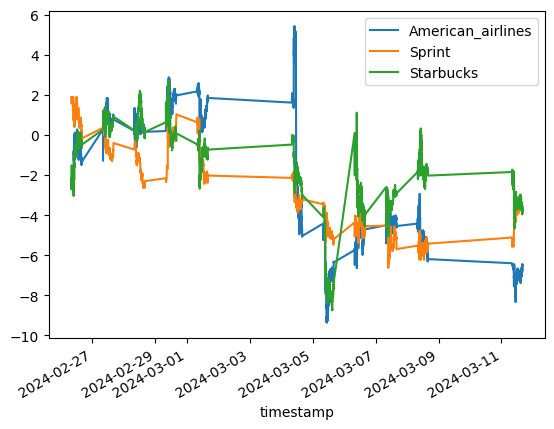

In [18]:
# Three columns
seven_dfs.iloc[:, [0, 8, 10]].plot()

Those long horizontal lines frightened me half to death when I first saw them, but it turns out to not be bad at all (except visually). The graph still includes those after-hours times in the x-axis even though there's no price there. This means that in reality those long bars are just illustrating the difference between two adjacent data points which happen to be far apart in real time.

This was good to see, as there's no obvious pattern to what happens to prices during those times.

How much does a stock's price tend to move through the day? I should know what I'm working with to make sure that the predictions I'm trying to make have the potential to be meaningful.

Text(0.5, 1.0, 'All 7 Stocks on a Given Day')

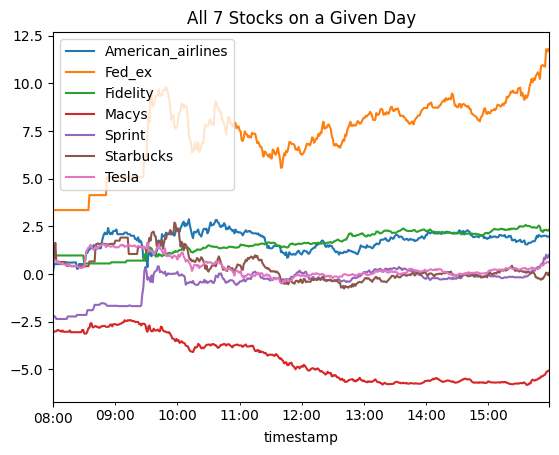

In [19]:
# Over the course of one day:
seven_dfs.iloc[:,prices][1440:1920].plot()
plt.title("All 7 Stocks on a Given Day")

There is a lack of normal activity in the first hour or so of my current window. In a moment, I'll set my early boundary to be 9am.

In the meantime, I have yet to see if it's even meaningful to guess how much prices move in the timeframes I'm proposing we make our predictions in. So how much can they change in 60 minutes?

Text(0.5, 1.0, 'All 7 Stocks on a Given Hour')

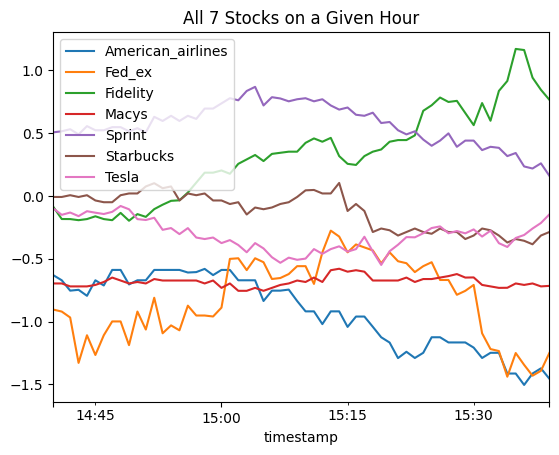

In [20]:
seven_dfs.iloc[:,prices][400:460].plot()
plt.title("All 7 Stocks on a Given Hour")

Sometimes, quite a bit! Fidelity's price rose by an entire standard deviation in about 50 minutes.

What about in an arbitrary half-hour?

Text(0.5, 1.0, 'All 7 Stocks on a Given Half Hour')

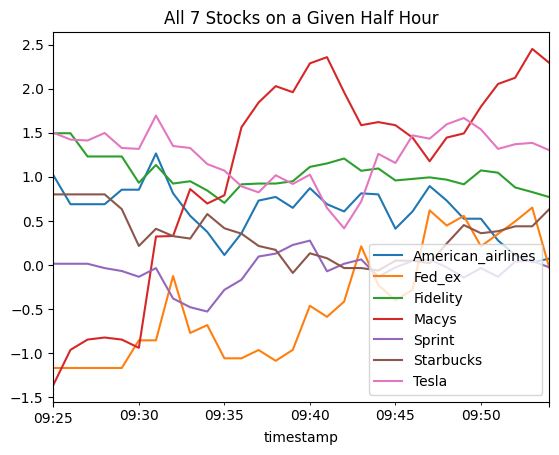

In [21]:
seven_dfs.iloc[:,prices][565:595].plot()

plt.title("All 7 Stocks on a Given Half Hour")

This time, it's Macy's that's shot up by nearly three standard deviations.

That was all promising. Oh, and before I had a chance to forget, I removed the first hour's prices from the list so we are starting at 9am proper.

In [22]:
seven_dfs.drop(seven_dfs[seven_dfs["hour"] < 9].index, inplace = True)

Which left me with this many data points for prices:

In [23]:
len(seven_dfs)*7

32340

# 2.0 Building the Model

The following code creates the walk-forward system, but was changed largely to fit the fact that this is a multivariate analysis with about half of the columns containing data that will become target variables. It altogether turns the DF into Xs and ys.

Feed it any amount of time (say, one hour) and it will return that many rows to use as one batch (the first X), then it will jump ahead bu that much time and create that X's target variable (the first y). Then it will collect the subsequent batch of time (to make the second X), jump ahead again (to make the second y), until the dataframe is exhausted.

In [24]:
# Code repurposed from Greg Hogg: https://www.youtube.com/watch?v=c0k-YLQGKjY
def df_to_Xy(df, window):
  df_np = df.to_numpy()
  X = []
  y = []
  for i in range(0, len(df)-window, window):
    rows = [a for a in df_np[i:i+window]] #Collecting the batch to make Xs
    X.append(rows) # Taking that whole batch in as a single list
    y.append(df_np[i+window][prices]) # the price to guess, a little farther out
  return np.array(X), np.array(y,dtype=np.float32)

In [25]:
# Creating the independant and target variables, as explained above.
X25, y25 = df_to_Xy(seven_dfs, 25) #25 minute steps
X34, y34 = df_to_Xy(seven_dfs, 34) #34 minute steps
X45, y45 = df_to_Xy(seven_dfs, 45) #45 minute steps
X60, y60 = df_to_Xy(seven_dfs, 60) #60 minute steps

In [26]:
# Delineating train/val/test sets
X_train25, y_train25 = X25[:129], y25[:129] #Just over 70% of the data
X_val25, y_val25 = X25[129:157], y25[129:157]
X_test25, y_test25 = X25[157:], y25[157:] #50/50 split between val and test

X_train34, y_train34 = X34[:95], y34[:95]
X_val34, y_val34 = X34[95:115], y34[95:115]
X_test34, y_test34 = X34[115:], y34[115:]

X_train45, y_train45 = X45[:72], y45[:72]
X_val45, y_val45 = X45[72:87], y45[72:87]
X_test45, y_test45 = X45[87:], y45[87:]

X_train60, y_train60 = X60[:55], y60[:55]
X_val60, y_val60 = X60[55:65], y60[55:65]
X_test60, y_test60 = X60[65:], y60[65:]

Below are just the functions used for graphing. In order, they will: show a particular prediction and price in dollars; show all of a model's predictions and prices but scaled; and show the training/validation loss curves.

In [27]:
# Returns one stock, unscaled
def pred_plot_real(model, X, y, col):
  preds = scaler.inverse_transform(model.predict(X))[:,col]
  actuals = scaler.inverse_transform(y)[:,col]
  df = pd.DataFrame(data={"Predictions":preds, "Actuals":actuals})
  plt.plot(df["Predictions"][:], label = "Predictions")
  plt.plot(df["Actuals"][:], label = "Actuals")
  plt.legend()
  plt.title(stock_names[col] + " Prediction vs Actual in Dollars")
  plt.xlabel("Step Number")
  plt.ylabel("Price in Dollars")
  plt.show()

# Reurns all predictions/actuals in a 4x2 array, scaled
def pred_plot_all(model_fam, index, X, y):
  fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
  fig.set_figheight(22)
  fig.set_figwidth(15)
  fig.suptitle(model_fam[1][index])
  axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
  for i, ax in enumerate(axes):
    actual = y[:,i].flatten()
    preds = model_fam[0][index].predict(X)[:,i].flatten()
    ax = ax
    ax.plot(preds)
    ax.plot(actual)
    ax.legend(["Prediction", "Actual"])
    ax.set_title(stock_names[i] + " Prediction vs Actual")
    plt.legend()
  plt.show()

# Plots the train vs validation error for any particular model
def plot_error(history):
  hist_dict = history.history
  rmse = hist_dict["root_mean_squared_error"]
  v_rmse = hist_dict["val_root_mean_squared_error"]
  df = pd.DataFrame(data={"Train_error":rmse, "Val_Error":v_rmse})
  plt.plot(df["Train_error"][:], label = "Train error")
  plt.plot(df["Val_Error"][:], label = "Val Error")
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

I chose two variables to adjust, and each one has two states:

Learning rate, which is either
Default (0.0001) or Fast (0.01).
Number of hidden layers: Short (2) vs Long (4)

Given more resources (specifically time), something closer to a grid search would have been more appropriate.

Below all of the models, histories, model names, and more are organized so they can be referenced by the functions above.

In [28]:
# All of the training and validation datasets
the_X_trains = [X_train25, X_train34, X_train45, X_train60]
the_y_trains = [y_train25, y_train34, y_train45, y_train60]

the_X_vals = [X_val25, X_val34, X_val45, X_val60]
the_y_vals = [y_val25, y_val34, y_val45, y_val60]



## Just the Default/Short models

#Instantiation
mod_25_DeSh = Sequential()
mod_34_DeSh = Sequential()
mod_45_DeSh = Sequential()
mod_60_DeSh = Sequential()

#Checkpoints
cp_25_DeSh = ModelCheckpoint("model_25_DeSh/", save_best_only=True)
cp_34_DeSh = ModelCheckpoint("model_34_DeSh/", save_best_only=True)
cp_45_DeSh = ModelCheckpoint("model_45_DeSh/", save_best_only=True)
cp_60_DeSh = ModelCheckpoint("model_60_DeSh/", save_best_only=True)

cps_DeSh = [cp_25_DeSh, cp_34_DeSh, cp_45_DeSh, cp_60_DeSh]

#Empty histories, which will be called later
hist_25_DeSh = None
hist_34_DeSh = None
hist_45_DeSh = None
hist_60_DeSh = None

hists_DeSh = [hist_25_DeSh, hist_34_DeSh, hist_45_DeSh, hist_60_DeSh]

#Partnered lists, so models and their names can be called by enumerate()
mods_DeSh = [mod_25_DeSh, mod_34_DeSh, mod_45_DeSh, mod_60_DeSh]
mods_DeSh_str = ["mod_25_DeSh", "mod_34_DeSh", "mod_45_DeSh", "mod_60_DeSh"]
DeSh_both = [mods_DeSh, mods_DeSh_str]


## Fast/Short
mod_25_FaSh = Sequential()
mod_34_FaSh = Sequential()
mod_45_FaSh = Sequential()
mod_60_FaSh = Sequential()

cp_25_FaSh = ModelCheckpoint("model_25_FaSh/", save_best_only=True)
cp_34_FaSh = ModelCheckpoint("model_34_FaSh/", save_best_only=True)
cp_45_FaSh = ModelCheckpoint("model_45_FaSh/", save_best_only=True)
cp_60_FaSh = ModelCheckpoint("model_60_FaSh/", save_best_only=True)

hist_25_FaSh = None
hist_34_FaSh = None
hist_45_FaSh = None
hist_60_FaSh = None

mods_FaSh = [mod_25_FaSh, mod_34_FaSh, mod_45_FaSh, mod_60_FaSh]
mods_FaSh_str = ["mod_25_FaSh", "mod_34_FaSh", "mod_45_FaSh", "mod_60_FaSh"]
FaSh_both = [mods_FaSh, mods_FaSh_str]

cps_FaSh = [cp_25_FaSh, cp_34_FaSh, cp_45_FaSh, cp_60_FaSh]

hists_FaSh = [hist_25_FaSh, hist_34_FaSh, hist_45_FaSh, hist_60_FaSh]


## Default/Long
mod_25_DeLo = Sequential()
mod_34_DeLo = Sequential()
mod_45_DeLo = Sequential()
mod_60_DeLo = Sequential()

cp_25_DeLo = ModelCheckpoint("model_25_DeLo/", save_best_only=True)
cp_34_DeLo = ModelCheckpoint("model_34_DeLo/", save_best_only=True)
cp_45_DeLo = ModelCheckpoint("model_45_DeLo/", save_best_only=True)
cp_60_DeLo = ModelCheckpoint("model_60_DeLo/", save_best_only=True)

hist_25_DeLo = None
hist_34_DeLo = None
hist_45_DeLo = None
hist_60_DeLo = None

mods_DeLo = [mod_25_DeLo, mod_34_DeLo, mod_45_DeLo, mod_60_DeLo]
mods_DeLo_str = ["mod_25_DeLo", "mod_34_DeLo", "mod_45_DeLo", "mod_60_DeLo"]
DeLo_both = [mods_DeLo, mods_DeLo_str]

cps_DeLo = [cp_25_DeLo, cp_34_DeLo, cp_45_DeLo, cp_60_DeLo]

hists_DeLo = [hist_25_DeLo, hist_34_DeLo, hist_45_DeLo, hist_60_DeLo]


## Fast/Long
mod_25_FaLo = Sequential()
mod_34_FaLo = Sequential()
mod_45_FaLo = Sequential()
mod_60_FaLo = Sequential()

cp_25_FaLo = ModelCheckpoint("model_25_FaLo/", save_best_only=True)
cp_34_FaLo = ModelCheckpoint("model_34_FaLo/", save_best_only=True)
cp_45_FaLo = ModelCheckpoint("model_45_FaLo/", save_best_only=True)
cp_60_FaLo = ModelCheckpoint("model_60_FaLo/", save_best_only=True)

hist_25_FaLo = None
hist_34_FaLo = None
hist_45_FaLo = None
hist_60_FaLo = None

mods_FaLo = [mod_25_FaLo, mod_34_FaLo, mod_45_FaLo, mod_60_FaLo]
mods_FaLo_str = ["mod_25_FaLo", "mod_34_FaLo", "mod_45_FaLo", "mod_60_FaLo"]
FaLo_both = [mods_FaLo, mods_FaLo_str]

cps_FaLo = [cp_25_FaLo, cp_34_FaLo, cp_45_FaLo, cp_60_FaLo]

hists_FaLo = [hist_25_FaLo, hist_34_FaLo, hist_45_FaLo, hist_60_FaLo]

I gave models with a fast learning rate a maximum of 30 epochs to train, but few if any needed that long. The default learning rate-models were given 300 epochs, and many of them could have used even *more* time.

## Model type 1: Default LR, Shorter Network


The first attempt will use the slow learning rate and a shot-in-the-dark short list of hidden layers. There were 16 columns worth of data (7 prices, 7 volumes, day, and time) so it began with 16 nodes, which I hoped would feed into 14 nodes (2 for each price).

If I knew how long these cells would take to run and how many times I would have had to rerun them, I would have chosen a learning rate an order of magnitude greater to be my low end. At least.

In [32]:
# Default and Short models
for i, n in enumerate([25, 34, 45, 60]):
  mods_DeSh[i].add(InputLayer((n,16)))
  mods_DeSh[i].add(GRU(64))
  mods_DeSh[i].add(Dense(16, "relu"))
  mods_DeSh[i].add(Dense(14, "relu"))
  mods_DeSh[i].add(Dense(7, "linear"))

  mods_DeSh[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.0001),
                        metrics=[RootMeanSquaredError()])

  print("Default and Short, samples = " + str(n))
  hists_DeSh[i] = mods_DeSh[i].fit(the_X_trains[i], the_y_trains[i],
      validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 300,
      callbacks = [cps_DeSh[i], EarlyStopping(patience=5, start_from_epoch=10)])

  print("\n")
  print("\n")

Default and Short, samples = 25
Epoch 1/300
5/5 [==============================] - 7s 1s/step - loss: 13.6517 - root_mean_squared_error: 3.6948 - val_loss: 33.8670 - val_root_mean_squared_error: 5.8195
Epoch 2/300
5/5 [==============================] - 4s 1s/step - loss: 13.6025 - root_mean_squared_error: 3.6882 - val_loss: 33.7247 - val_root_mean_squared_error: 5.8073
Epoch 3/300
5/5 [==============================] - 3s 828ms/step - loss: 13.5580 - root_mean_squared_error: 3.6821 - val_loss: 33.6069 - val_root_mean_squared_error: 5.7971
Epoch 4/300
5/5 [==============================] - 4s 1s/step - loss: 13.5087 - root_mean_squared_error: 3.6754 - val_loss: 33.5099 - val_root_mean_squared_error: 5.7888
Epoch 5/300
5/5 [==============================] - 3s 834ms/step - loss: 13.4636 - root_mean_squared_error: 3.6693 - val_loss: 33.4049 - val_root_mean_squared_error: 5.7797
Epoch 6/300
5/5 [==============================] - 4s 1s/step - loss: 13.4272 - root_mean_squared_error: 3.6643 

In [35]:
error_list = [] #for storing and retrieving the best model

In [37]:
for i, n in enumerate([25, 34, 45, 60]):
  score = min(hists_DeSh[i].history['val_root_mean_squared_error'])

  print(str(score) + " = Default/Short best Val RMSE with samples sized " + str(n))

  error_list.append(score)

  print("\n")

3.886950731277466 = Default/Short best Val RMSE with samples sized 25


4.302043914794922 = Default/Short best Val RMSE with samples sized 34


3.924981117248535 = Default/Short best Val RMSE with samples sized 45


4.398299694061279 = Default/Short best Val RMSE with samples sized 60




Thus far, the best model has a RMSE of 3.89. Considering these are standard deviations, that's pretty rough.

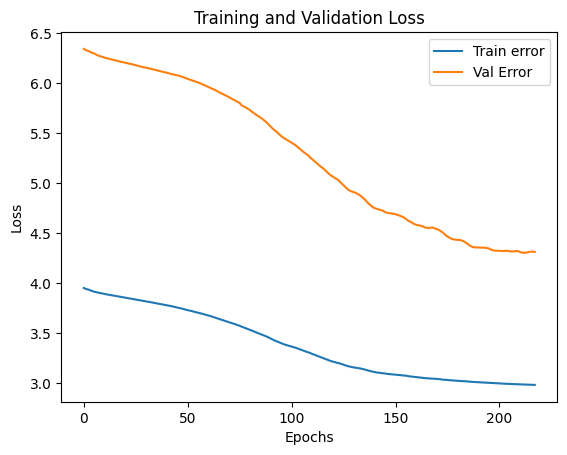

In [ ]:
plot_error(hists_DeSh[0])

It appears that while the two curves haven't really converged for this model (the gap has only shrunk by about a third), we probably just passed an inflection point. Now the rate of the decrease is itself decreasing. The return on investment timewise in pushing through more epochs is very unappealing.

These models were ultimately unlikely to lead anywhere good, and their progress ultimately resulted in the below graphs for the most performant one.

1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


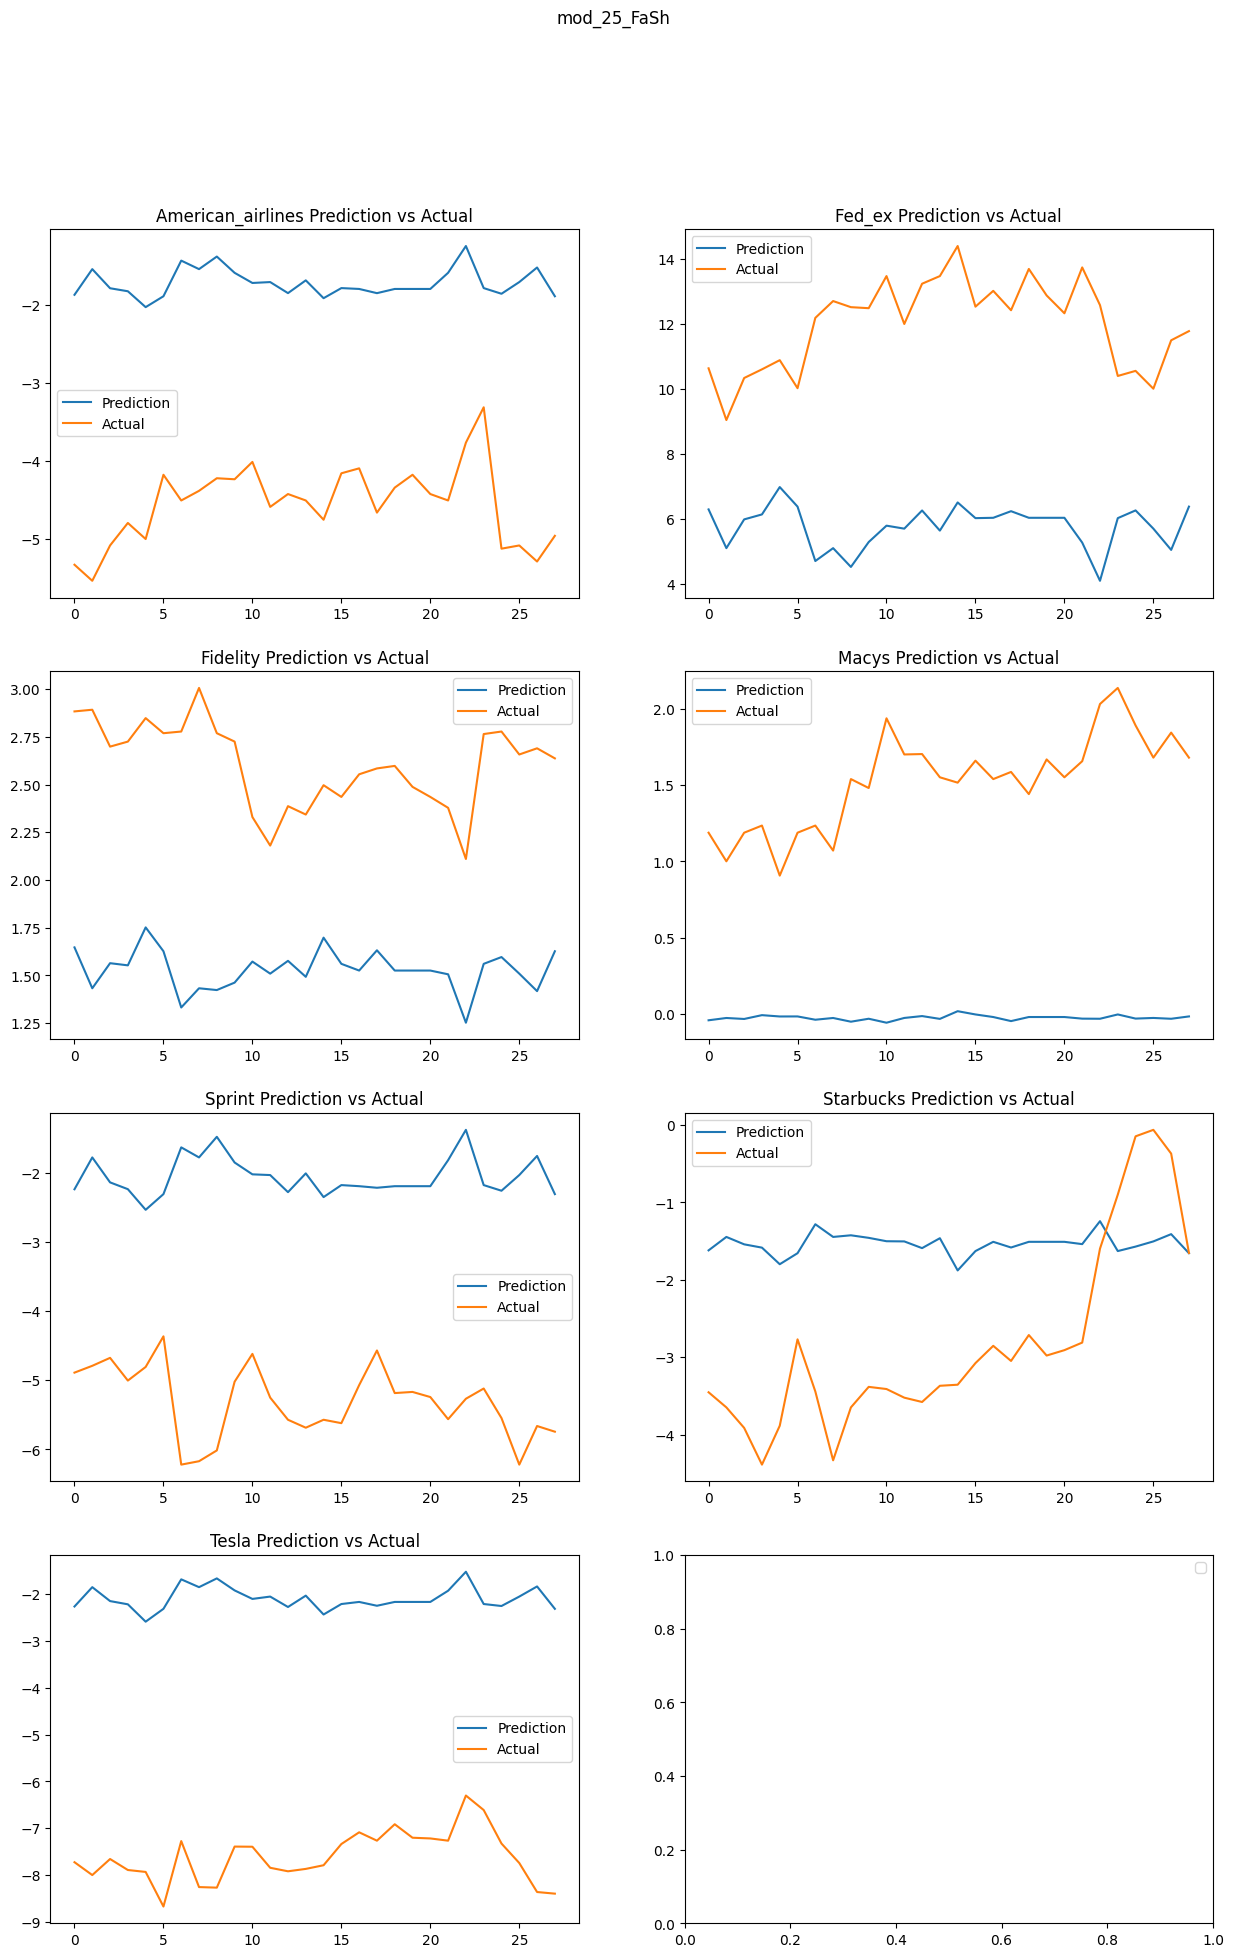

In [50]:
# 25 min steps, Default Learning Rate + Short Network
pred_plot_all(FaSh_both, 0, X_val25, y_val25)

Bear with me a moment while I zoom in on just the last graph here, the one for Tesla.

1/1 [==============================] - 0s 45ms/step


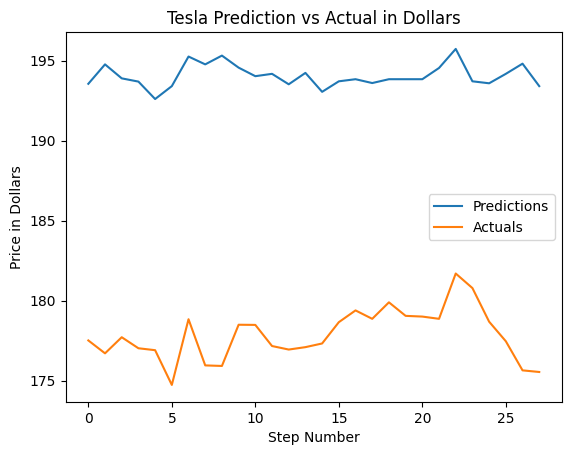

In [51]:
pred_plot_real(mod_25_FaSh, X_val25, y_val25, 6)

Why is there so much bias here? At first I thought "If *I'm* smart enough to realize it should add 15 dollars to the price, why isn't the model?"

Well, if you look at the other graphs they show a similar bias, but it's mixed between being consistently overshooting and undershooting. I assume that it's this mixture, born from training on multiple stocks, which explains it away. If I trained on Tesla alone, perhaps we'd see something different.

All of the other De/Sh models were about as bad. I'll spare you the gory details of those graphs, except for one glimmer here:


predicted price:
1/1 [==============================] - 0s 46ms/step
27.90035
actual price:
27.83
1/1 [==============================] - 0s 56ms/step


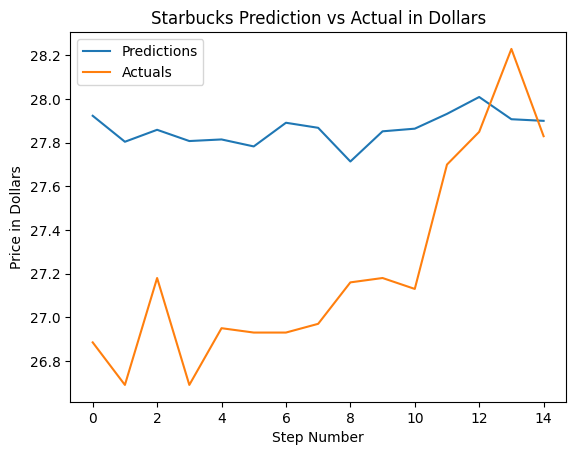

In [55]:
print("predicted price:")
print(scaler.inverse_transform(mod_45_DeSh.predict(X_val45))[:,5][14])
print("actual price:")
print(scaler.inverse_transform(y_val45)[:,5][14])
pred_plot_real(mod_45_DeSh, X_val45, y_val45, 5)

There, at the 14th prediction, it got within about 7 cents of the correct answer. Cause for optimism, or random noise?

In any case, let's skip to the second model.

## Model Type 2: Default LR and a Longer Network

These models were marginally better than those before, which is to say not very good either.

In [33]:
# Default and Long models
for i, n in enumerate([25, 34, 45, 60]):
  mods_DeLo[i].add(InputLayer((n,16)))
  mods_DeLo[i].add(GRU(64))
  mods_DeLo[i].add(Dense(16, "relu"))
  mods_DeLo[i].add(Dense(16, "relu"))
  mods_DeLo[i].add(Dense(15, "relu"))
  mods_DeLo[i].add(Dense(14, "relu"))
  mods_DeLo[i].add(Dense(7, "linear"))

  mods_DeLo[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.0001),
                        metrics=[RootMeanSquaredError()])

  print("Default and Long, samples = " + str(n))
  hists_DeLo[i] = mods_DeLo[i].fit(the_X_trains[i], the_y_trains[i],
      validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 300,
      callbacks = [cps_DeLo[i], EarlyStopping(patience=5, start_from_epoch=10)])


  print("\n")
  print("\n")

Default and Long, samples = 25
Epoch 1/300
5/5 [==============================] - 8s 1s/step - loss: 16.1350 - root_mean_squared_error: 4.0168 - val_loss: 40.6549 - val_root_mean_squared_error: 6.3761
Epoch 2/300
5/5 [==============================] - 5s 1s/step - loss: 16.0737 - root_mean_squared_error: 4.0092 - val_loss: 40.5328 - val_root_mean_squared_error: 6.3665
Epoch 3/300
5/5 [==============================] - 5s 1s/step - loss: 16.0190 - root_mean_squared_error: 4.0024 - val_loss: 40.4102 - val_root_mean_squared_error: 6.3569
Epoch 4/300
5/5 [==============================] - 4s 1s/step - loss: 15.9646 - root_mean_squared_error: 3.9956 - val_loss: 40.3052 - val_root_mean_squared_error: 6.3486
Epoch 5/300
5/5 [==============================] - 4s 1s/step - loss: 15.9077 - root_mean_squared_error: 3.9885 - val_loss: 40.1924 - val_root_mean_squared_error: 6.3397
Epoch 6/300
5/5 [==============================] - 6s 1s/step - loss: 15.8558 - root_mean_squared_error: 3.9819 - val_l

In [56]:
#Scores
for i, n in enumerate([25, 34, 45, 60]):
  score = min(hists_DeLo[i].history['val_root_mean_squared_error'])

  print(str(score) + " = Default/Long best Val RMSE with samples sized " + str(n))

  error_list.append(score)

  print("\n")

4.366778373718262 = Default/Long best Val RMSE with samples sized 25


3.8954930305480957 = Default/Long best Val RMSE with samples sized 34


3.813458204269409 = Default/Long best Val RMSE with samples sized 45


3.8869831562042236 = Default/Long best Val RMSE with samples sized 60




Once again, let's look only at a sample of what's here, the most performant model of the bunch (and consequently, of the 8 seen so far)

1/1 [==============================] - 1s 748ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 45ms/step


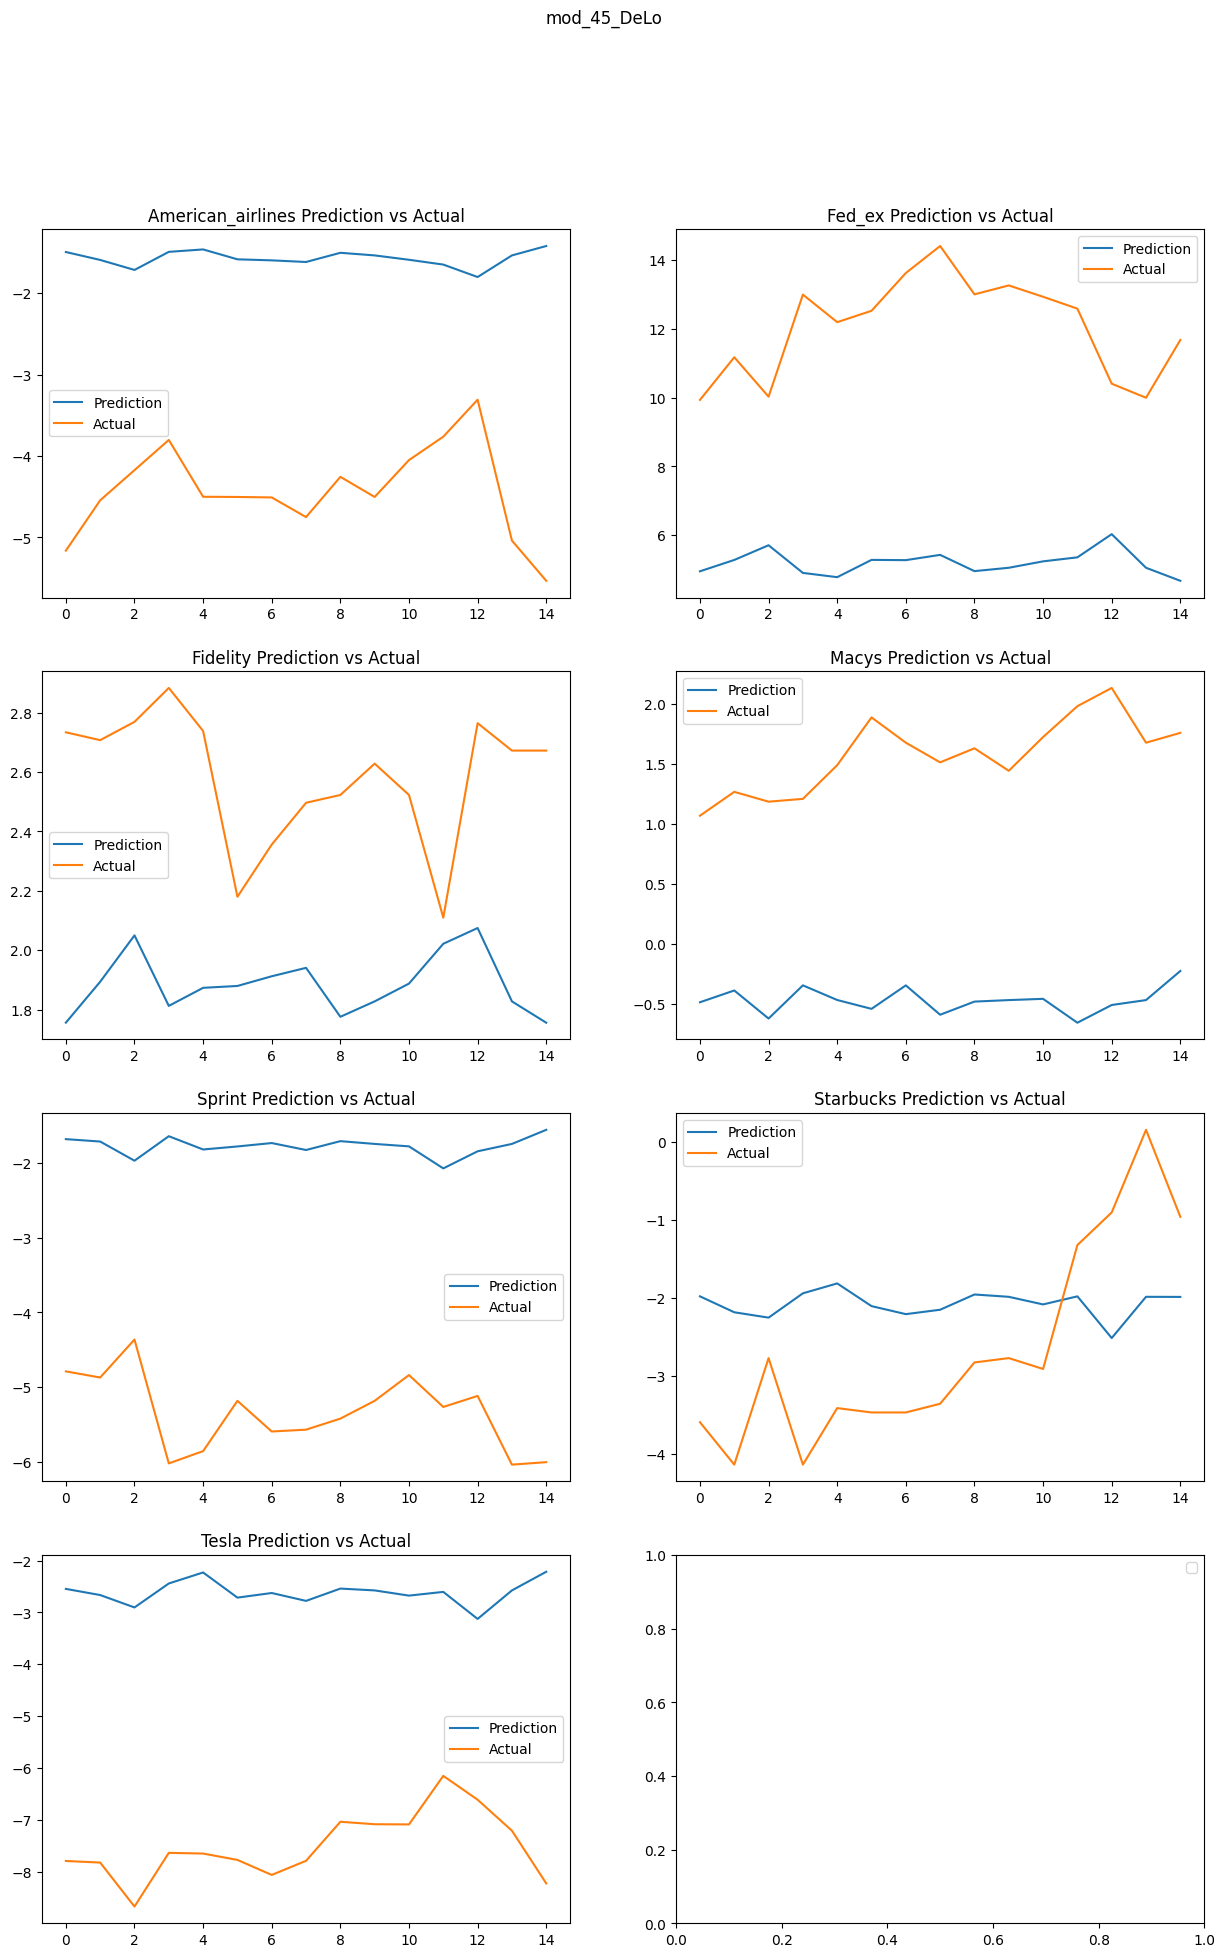

In [57]:
pred_plot_all(DeLo_both, 2, X_val45, y_val45)

## Model Type 3: Fast LR, Short Network

I expected to see a dramatic difference between the fast and slow models. While I did see them in some senses, where I did not see such differences was in the RMSE scores.

In [29]:
# Fast and Short models
for i, n in enumerate([25, 34, 45, 60]):
  mods_FaSh[i].add(InputLayer((n,16)))
  mods_FaSh[i].add(GRU(64))
  mods_FaSh[i].add(Dense(16, "relu"))
  mods_FaSh[i].add(Dense(14, "relu"))
  mods_FaSh[i].add(Dense(7, "linear"))

  mods_FaSh[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.01),
                        metrics=[RootMeanSquaredError()])

  print("Default and Long, samples = " + str(n))
  hists_FaSh[i] = mods_FaSh[i].fit(the_X_trains[i], the_y_trains[i],
  validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 30,
      callbacks = [cps_FaSh[i], EarlyStopping(patience=4, start_from_epoch=6)])



  print("\n")
  print("\n")

Default and Long, samples = 25
Epoch 1/30
5/5 [==============================] - 8s 970ms/step - loss: 14.6917 - root_mean_squared_error: 3.8330 - val_loss: 32.5322 - val_root_mean_squared_error: 5.7037
Epoch 2/30
5/5 [==============================] - 4s 1s/step - loss: 11.6293 - root_mean_squared_error: 3.4102 - val_loss: 22.5651 - val_root_mean_squared_error: 4.7503
Epoch 3/30
5/5 [==============================] - 3s 867ms/step - loss: 9.4447 - root_mean_squared_error: 3.0732 - val_loss: 15.7062 - val_root_mean_squared_error: 3.9631
Epoch 4/30
5/5 [==============================] - 3s 824ms/step - loss: 9.0556 - root_mean_squared_error: 3.0093 - val_loss: 13.7244 - val_root_mean_squared_error: 3.7046
Epoch 5/30
5/5 [==============================] - 0s 23ms/step - loss: 9.3848 - root_mean_squared_error: 3.0635 - val_loss: 15.9922 - val_root_mean_squared_error: 3.9990
Epoch 6/30
5/5 [==============================] - 0s 18ms/step - loss: 9.0447 - root_mean_squared_error: 3.0074 - va

The validation loss curve showed pretty messy behavior in the fast models, either by bouncing away from a path of steady improvement repeatedly or by diverging sharply all at once.

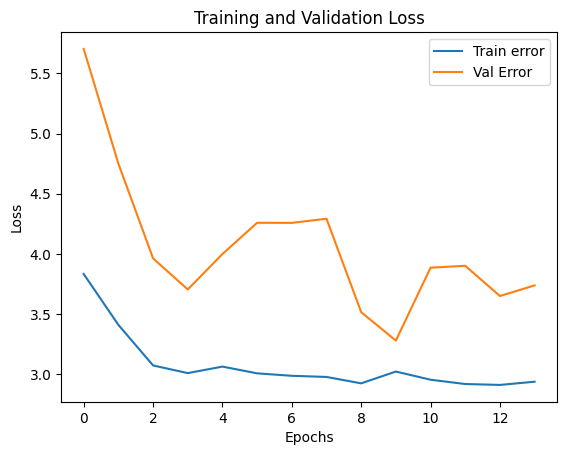

In [79]:
# The early patience params I set allowed the model to try to improve
# despite finding a local minima very early on
plot_error(hists_FaSh[0])

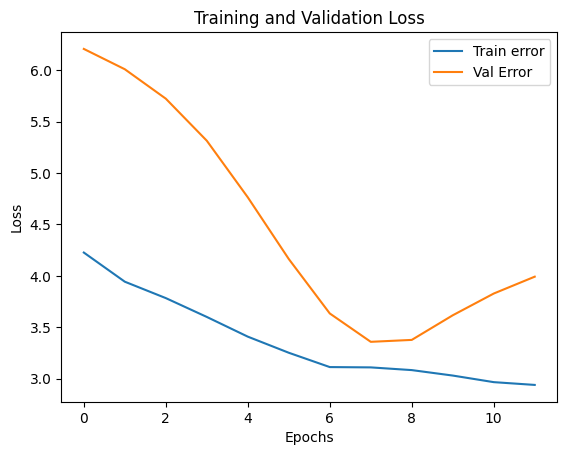

In [ ]:
plot_error(hists_FaSh[3])

The learning rate may be too high. I think it's bouncing around the local minima.

In [58]:
#The RMSE scores again
for i, n in enumerate([25, 34, 45, 60]):
  score = min(hists_FaSh[i].history['val_root_mean_squared_error'])

  print(str(score) + " = Fast/Short best Val RMSE with samples sized " + str(n))

  error_list.append(score)

  print("\n")

3.2796478271484375 = Fast/Short best Val RMSE with samples sized 25


3.925258159637451 = Fast/Short best Val RMSE with samples sized 34


3.421163320541382 = Fast/Short best Val RMSE with samples sized 45


3.3172190189361572 = Fast/Short best Val RMSE with samples sized 60




These are still quite far away from being useful on the whole, but this is a nice step forward. Let's again look at the best of these, which is againa 25 min step model.

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 38ms/step


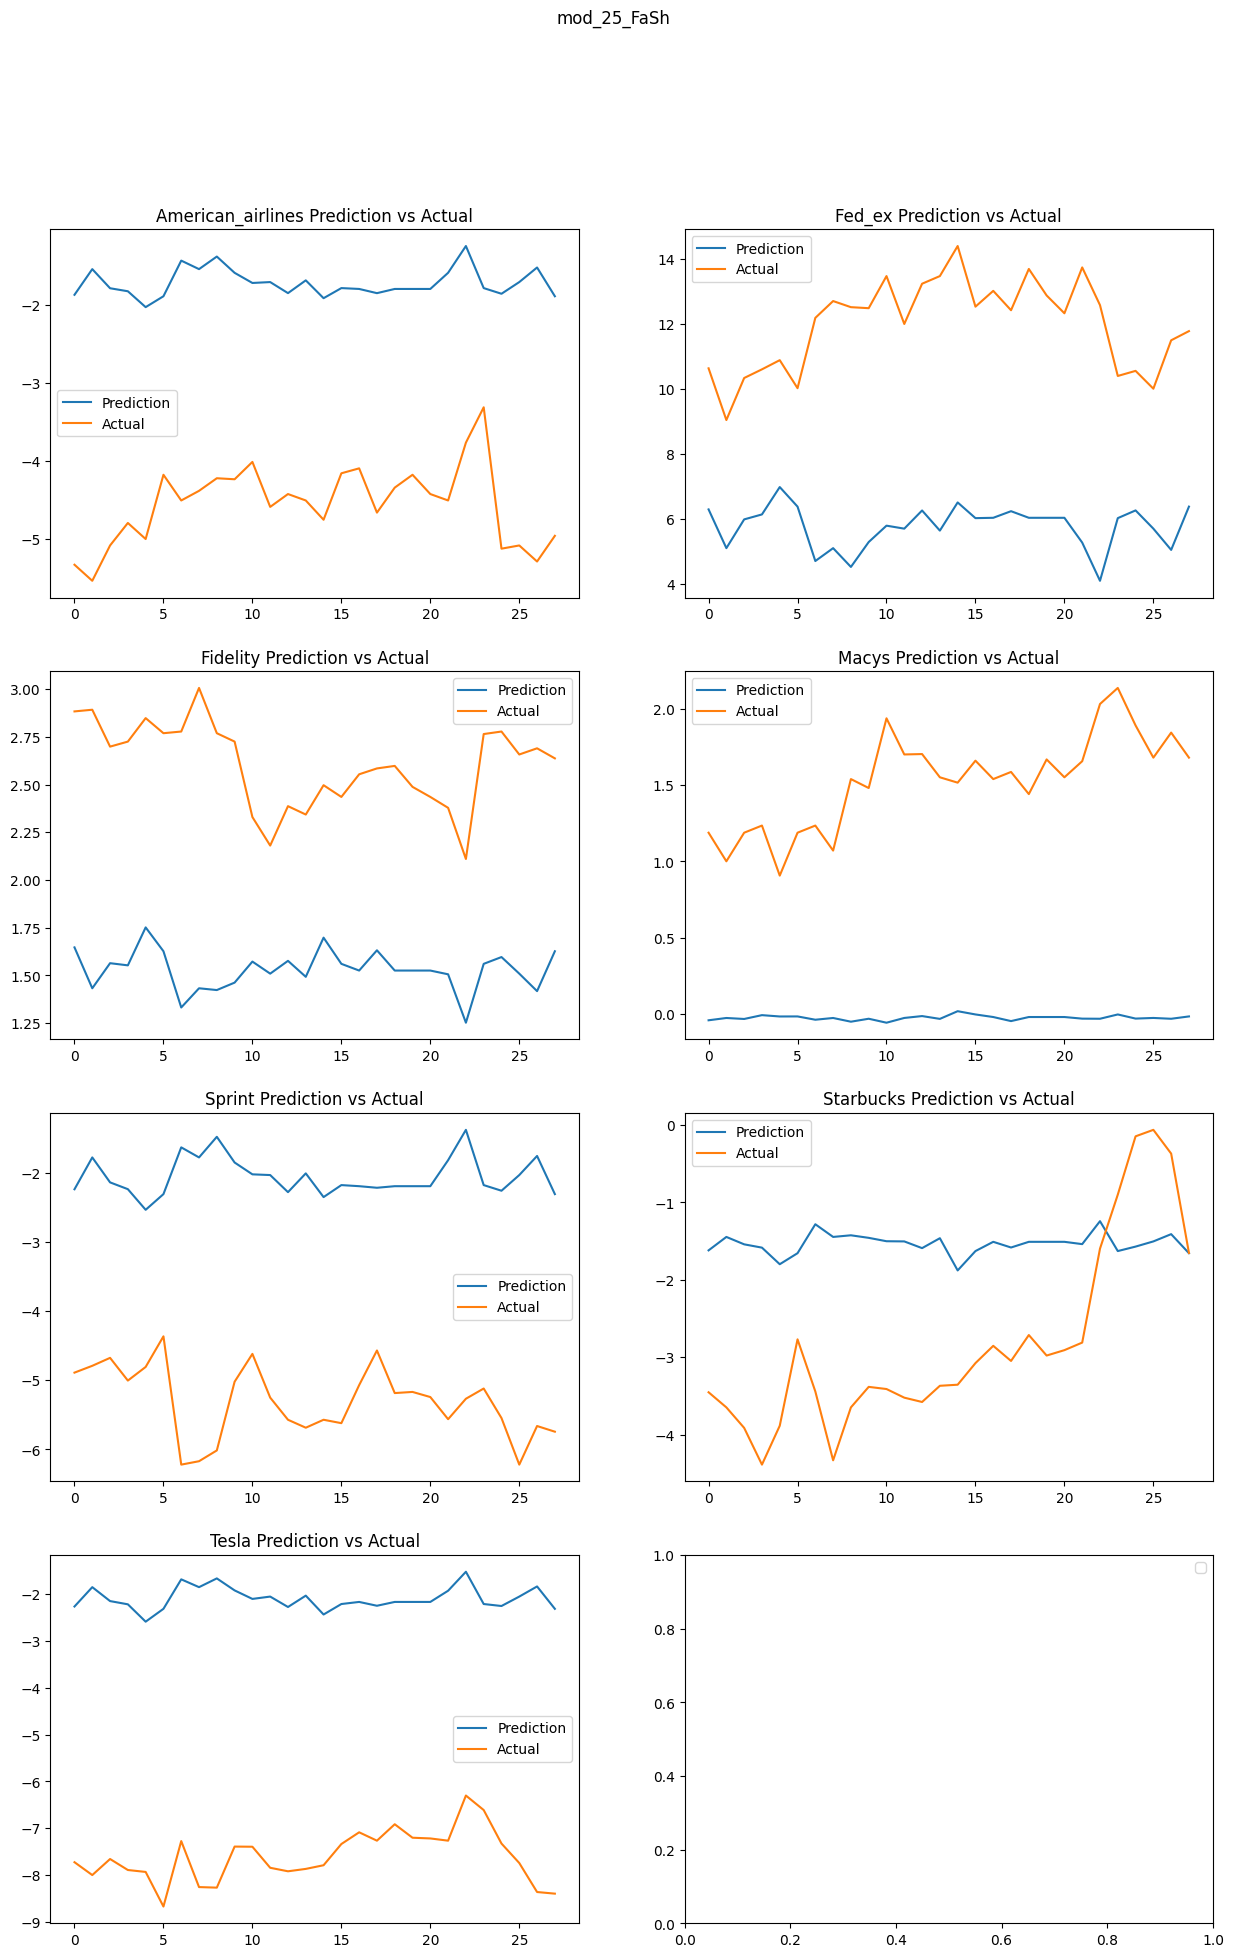

In [59]:
pred_plot_all(FaSh_both, 0, X_val25, y_val25)

There's something that's both troubling and funny in these graphs. Look at the predictions for Sprint and Tesla:

1/1 [==============================] - 0s 31ms/step


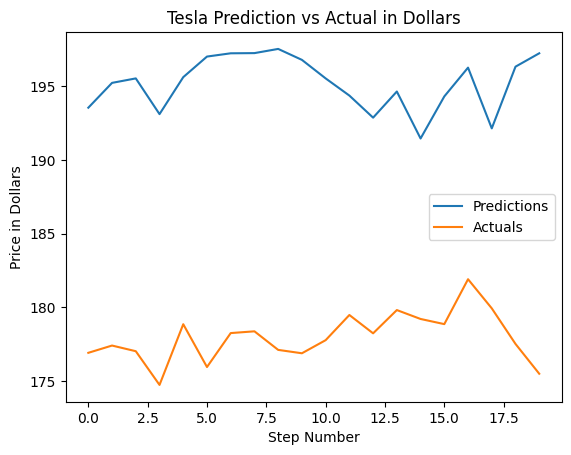

1/1 [==============================] - 0s 39ms/step


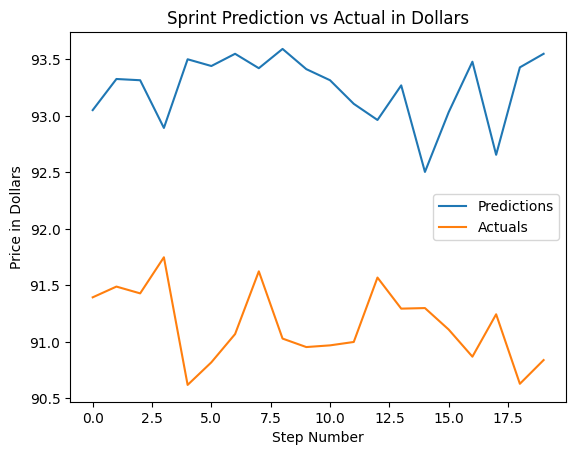

In [85]:
pred_plot_real(mod_34_FaSh, X_val34, y_val34, 6)
pred_plot_real(mod_34_FaSh, X_val34, y_val34, 4)

They appear to be identical! I was worried about the models getting lazy and trying to predict the prices to be the same as the last data point in X_val, but I didn't expect it to be lazy and plagairize itself!

## Model Type 4: Fast LR and Long Network
By now it should be clear that (at least on our scale) this is not a fruitful endeavor. But I may as well have that fruitlessness quantified.

In [34]:
# Fast and Long models
for i, n in enumerate([25, 34, 45, 60]):
  mods_FaLo[i].add(InputLayer((n,16)))
  mods_FaLo[i].add(GRU(64))
  mods_FaLo[i].add(Dense(16, "relu"))
  mods_FaLo[i].add(Dense(16, "relu"))
  mods_FaLo[i].add(Dense(15, "relu"))
  mods_FaLo[i].add(Dense(14, "relu"))
  mods_FaLo[i].add(Dense(7, "linear"))

  mods_FaLo[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.01),
                        metrics=[RootMeanSquaredError()])

  print("Default and Long, samples = " + str(n))
  hists_FaLo[i] = mods_FaLo[i].fit(the_X_trains[i], the_y_trains[i],
  validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 30,
      callbacks = [cps_FaLo[i], EarlyStopping(patience=4, start_from_epoch=6)])

  print("\n")
  print("\n")

Default and Long, samples = 25
Epoch 1/30
5/5 [==============================] - 8s 1s/step - loss: 14.7918 - root_mean_squared_error: 3.8460 - val_loss: 30.6723 - val_root_mean_squared_error: 5.5383
Epoch 2/30
5/5 [==============================] - 4s 894ms/step - loss: 11.2909 - root_mean_squared_error: 3.3602 - val_loss: 19.5980 - val_root_mean_squared_error: 4.4270
Epoch 3/30
5/5 [==============================] - 4s 1s/step - loss: 9.6118 - root_mean_squared_error: 3.1003 - val_loss: 15.2153 - val_root_mean_squared_error: 3.9007
Epoch 4/30
5/5 [==============================] - 4s 922ms/step - loss: 8.8619 - root_mean_squared_error: 2.9769 - val_loss: 12.3089 - val_root_mean_squared_error: 3.5084
Epoch 5/30
5/5 [==============================] - 0s 20ms/step - loss: 8.5935 - root_mean_squared_error: 2.9315 - val_loss: 15.3147 - val_root_mean_squared_error: 3.9134
Epoch 6/30
5/5 [==============================] - 0s 22ms/step - loss: 8.3871 - root_mean_squared_error: 2.8961 - val_l

The train-val loss curves have the wibbildy-wobbeldy quality like the previous batch. The learning rate is presumably jumping over the local minima, unable to converge.

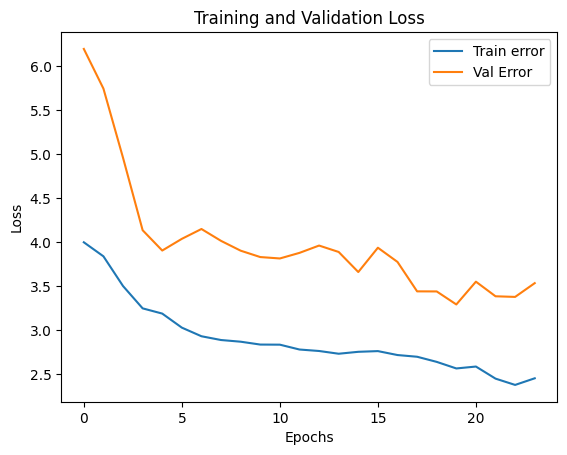

In [ ]:
plot_error(hists_FaLo[3])

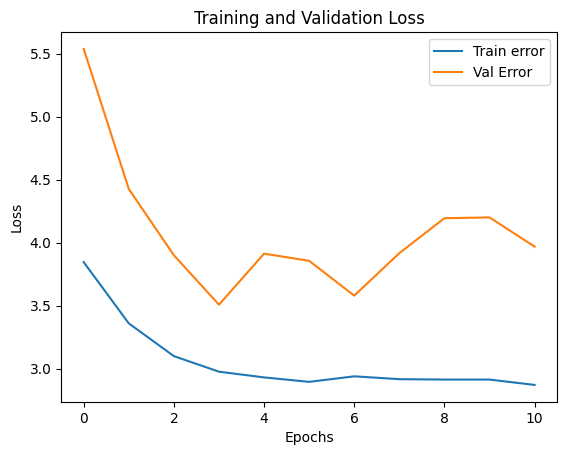

In [60]:
plot_error(hists_FaLo[0])

In [61]:
for i, n in enumerate([25, 34, 45, 60]):
  score = min(hists_FaLo[i].history['val_root_mean_squared_error'])

  print(str(score) + " = Fast/Long best Val RMSE with samples sized " + str(n))

  error_list.append(score)

  print("\n")

3.508410930633545 = Fast/Long best Val RMSE with samples sized 25


3.3892455101013184 = Fast/Long best Val RMSE with samples sized 34


3.627887010574341 = Fast/Long best Val RMSE with samples sized 45


3.5692532062530518 = Fast/Long best Val RMSE with samples sized 60




Nothing standing out here. Every model is about as messy as the last one. Perhaps the only differences are also random noise, like the stock prices themselves? This means that the best model was the 25-min step in the previous quartet.

1/1 [==============================] - 1s 772ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 68ms/step


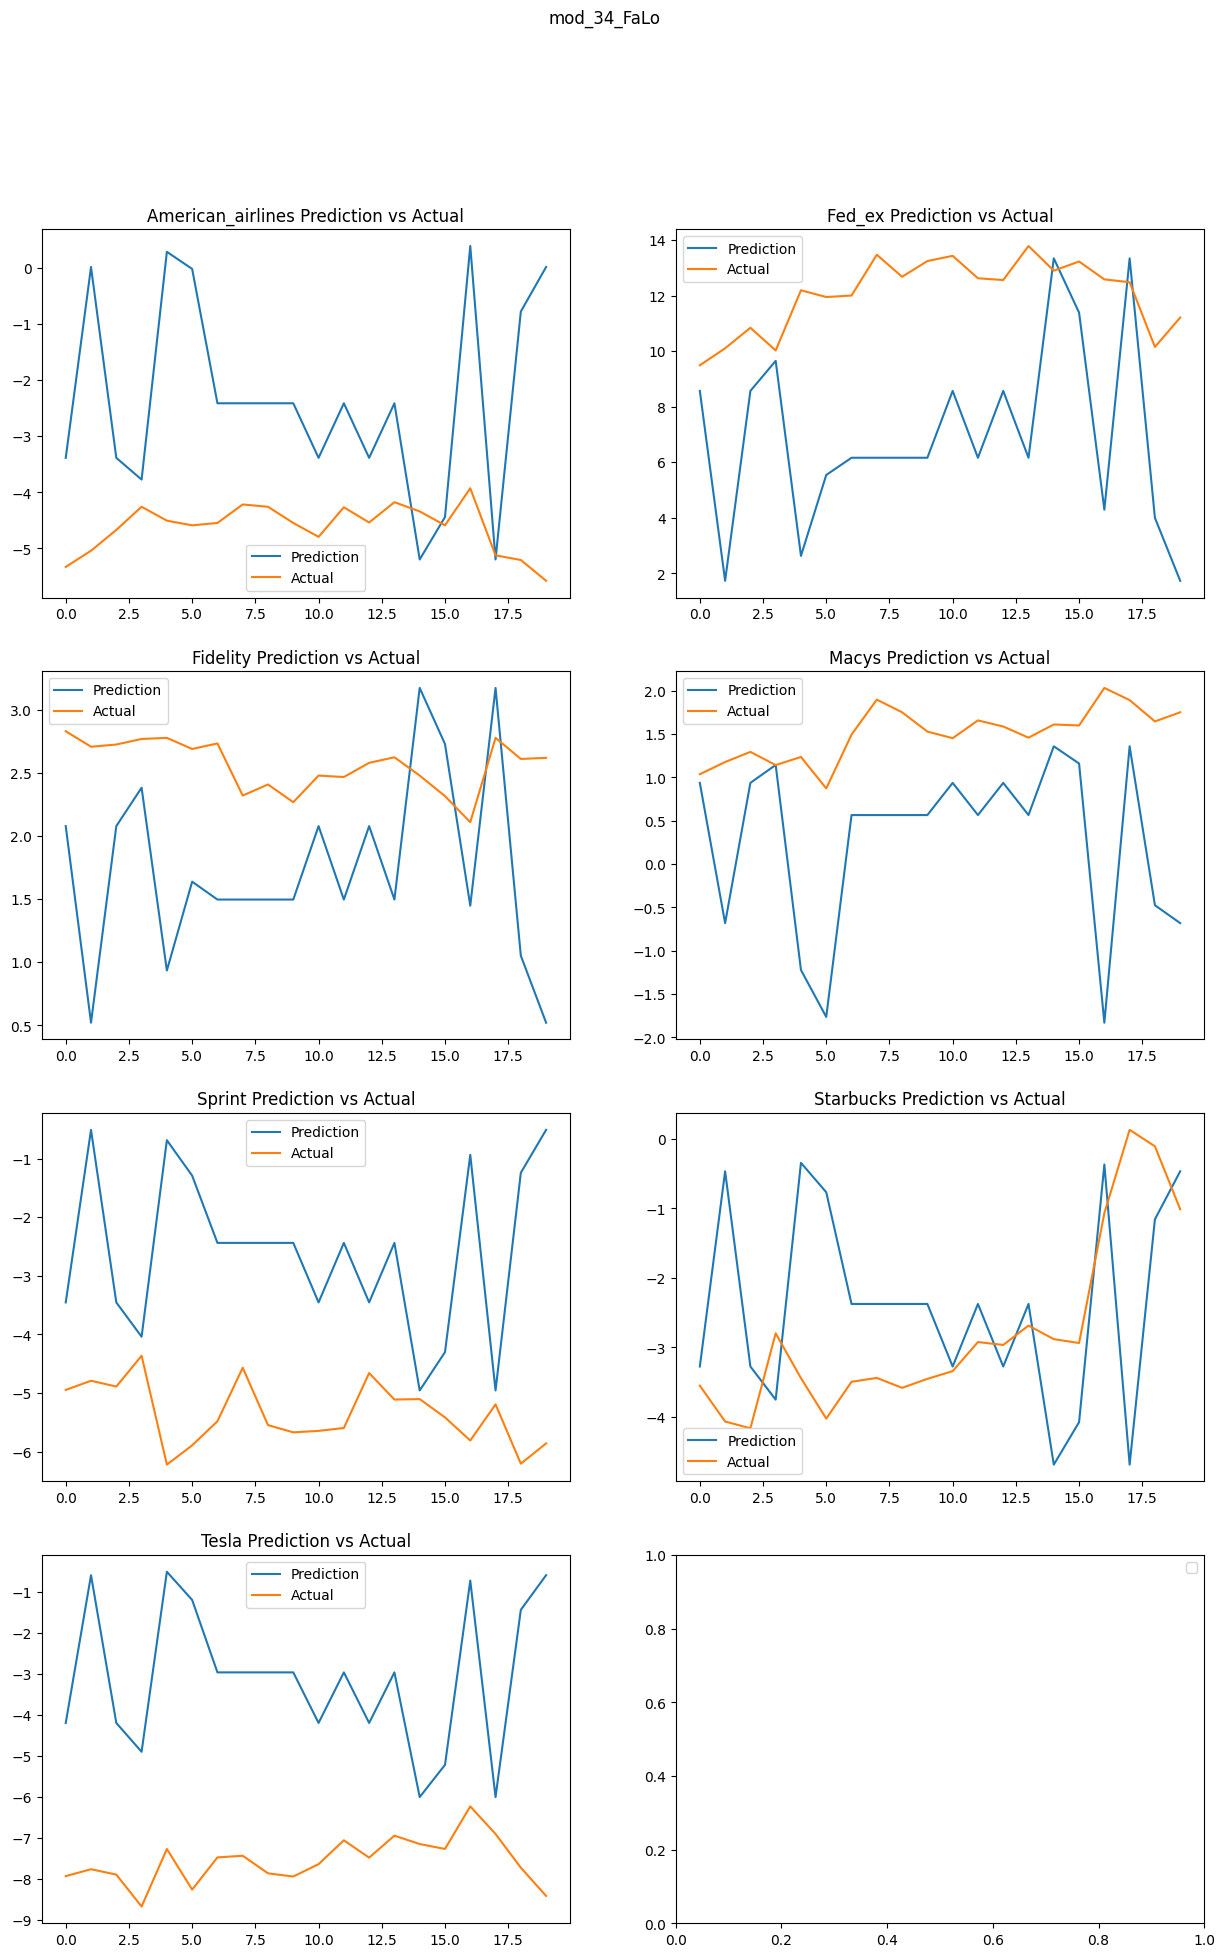

In [62]:
 pred_plot_all(FaLo_both, 1, X_val34, y_val34)

Many of these predictions bugger belief. Tesla here at around the 5th step was off by nearly *seven* standard deviations.

In [63]:
# Veryfying that this was indeed the best choice
min(error_list)

3.2796478271484375

This is the error associated with the Fast/Short model's 25 minute steps. Although I must reiterate my concerns that this may be a product of the stochastic process of gradient decent, and nothing more.

Alright, time to face our fate with the test data.

# Final Results and Conlcusions

1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


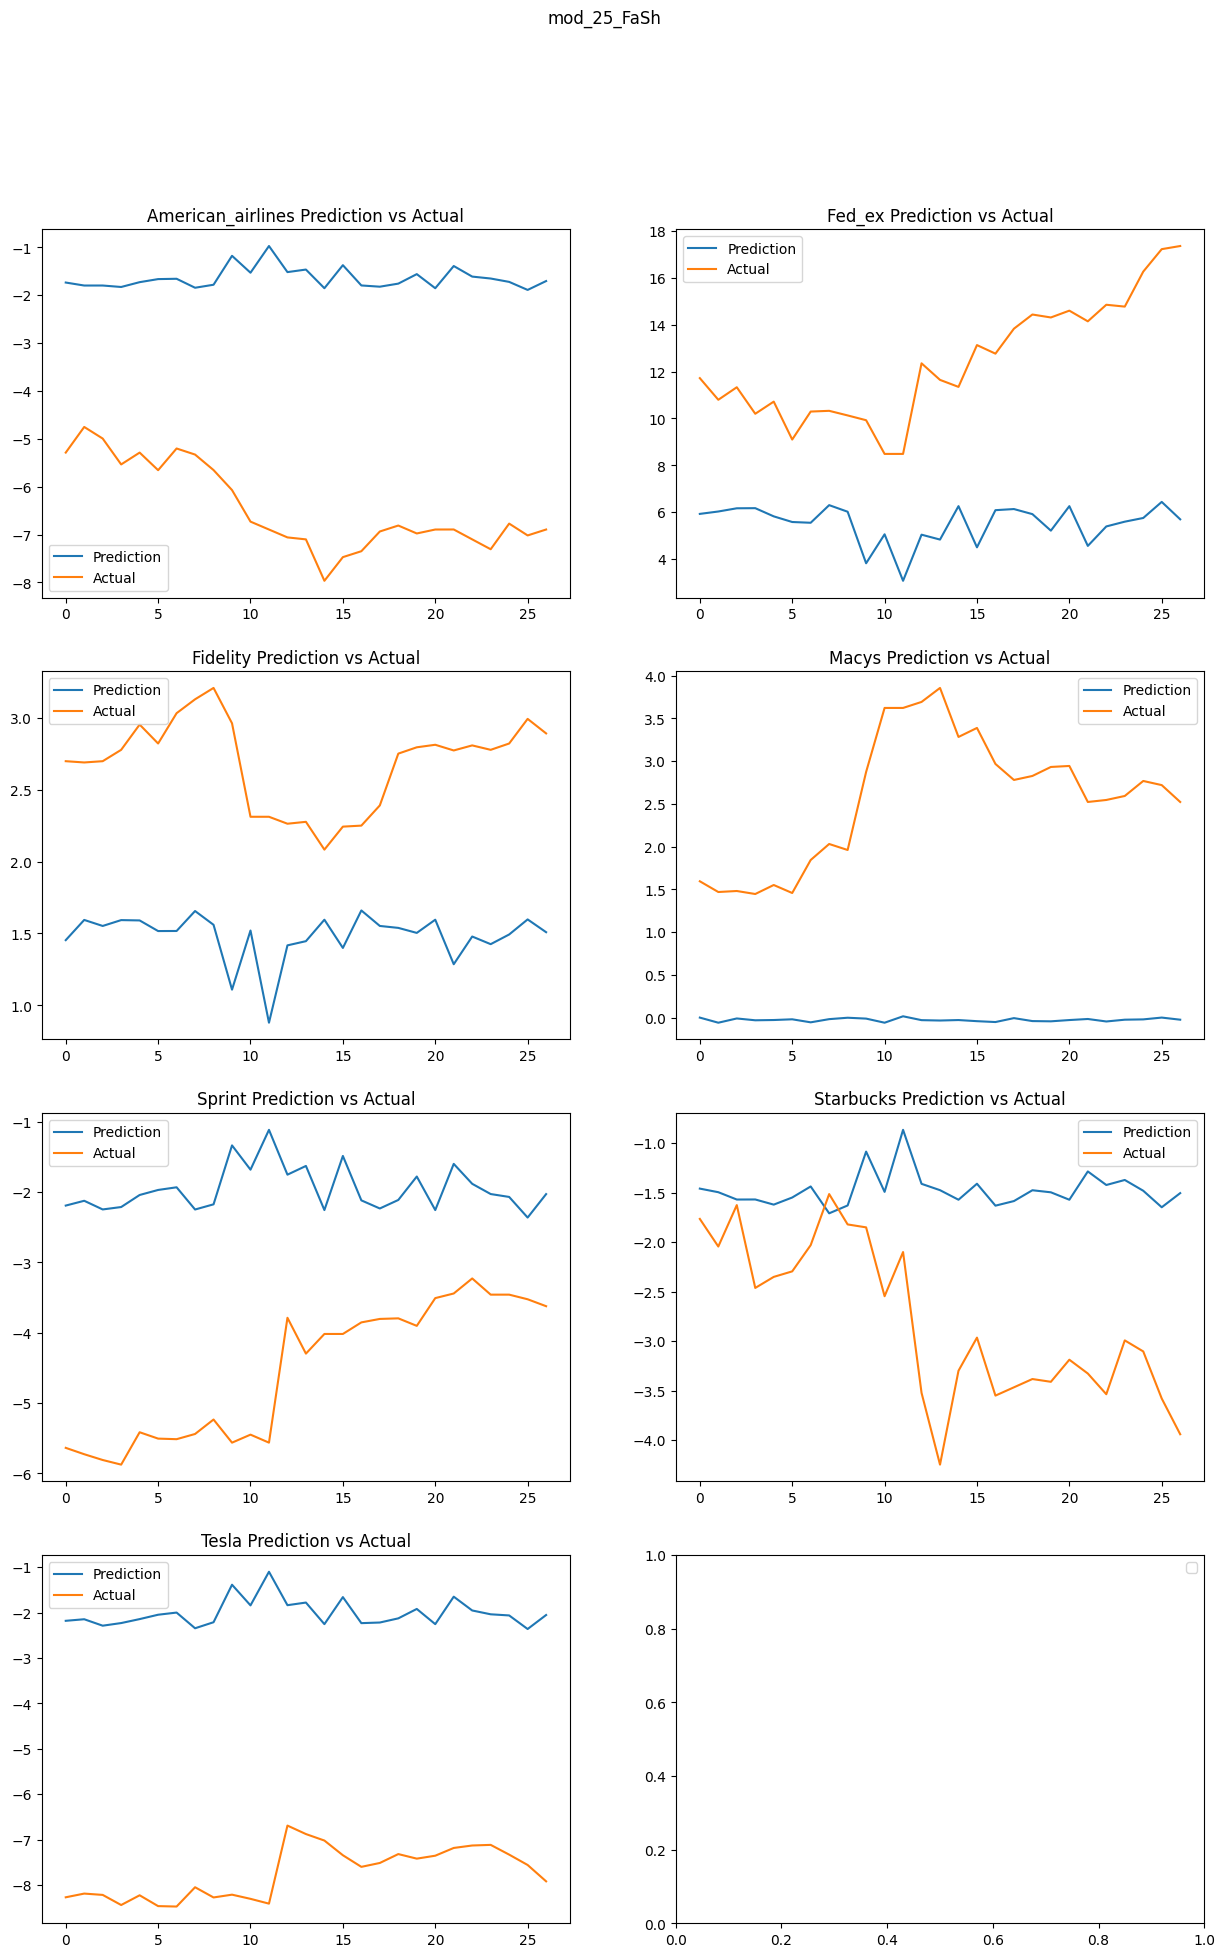

In [64]:
 pred_plot_all(FaSh_both, 0, X_test25, y_test25)

In [65]:
np.sqrt(mse(y_test25, mod_25_FaSh.predict(X_test25)))

1/1 [==============================] - 0s 44ms/step


4.2885904

Truly, these are some ghastly results. Here I sit, at age 34, about to use a phrase for the first (and hopefully last time). In italics, below:

The final prediction for Fed-Ex was ***wrong by ten standard deviations***

1/1 [==============================] - 0s 117ms/step


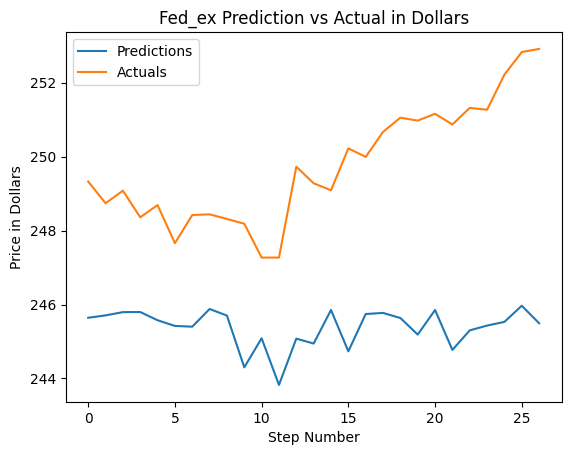

In [66]:
pred_plot_real(mod_25_FaSh, X_test25, y_test25, 1)

In [69]:
print("Fed-ex's max price over these 11 days")
print(all_dfs[1]["Fed_ex"].max())
print("Fed-ex's min price over that time")
print(all_dfs[1]["Fed_ex"].min())

Fed-ex's max price over these 11 days
253.37
Fed-ex's min price over that time
239.33


Strangely, the model predicted prices very near to the lowest price seen at all over that time, while the current prices were very nearly the highest they had ever been.

I'm tempted to say that this exercise confirms the well-held belief that this is in fact a fool's errand. It may in fact very well be.

## Conclusions

Ultimately, we must accept the null hypothesis. At this scale, with this computing power, the stocks may as well be noise.

 However I did learn something about modeling that I didn't expect: Here at the 11th hour of my time here at flatiron, I saw firsthand two competing models provide roughly equivalent results, despite one (the Default LR) taking about 50 times longer to train. That's an emotional lesson, delivered in numbers, that I can take with me long after I'm done here.

### Recommendations
I wouldn't suggest day trading. But if you were to continue, try to build off of my most performant model. In this and in previous iterations of this project, the shorter timescales seemed to work best. I am taking steps that only account for a small amount of time, you could very well find patterns that exist if you continue to make predictions in the very near term (20-30 mins) but use data from much farther behind.

### Next Steps
Have your team gather mountains more data. Squared or even cubed what I had. So much you may have to pay for it.

If you can, hire someone who can automatically scrape the internet for sentiments on the companies you're looking at. Apparently, tweets are good enough. And if you're interested, I may know someone who just did such a thing for his last (and more successful) project.